# 本次实验目录
- letter-recognition数据集
    - adaboost分类
    - 决策树分类
    - 朴素贝叶斯分类
    - svm分类
- glass数据集
    - adaboost分类
    - 决策树分类
    - 朴素贝叶斯分类
    - svm分类
- 分析汇总
    - 对比两个数据集上的ADABOOST
    - 对比每个数据集上的四个模型
- Adaboost
    - 存储结果说明
    - 算法思路设计

In [4]:
# 存储各个模型的评价指标
import pandas as pd

# 创建列名和行名
columns = ['letter_adaboost', 'letter_decision_tree', 'letter_naive_bayes', 'letter_svm', 'glass_adaboost', 'glass_decision_tree', 'glass_naive_bayes', 'glass_svm']
index = ['Accuracy', 'Precision', 'Recall', 'F1-measure']

# 创建空的DataFrame
evaluation_metrics = pd.DataFrame(columns=columns, index=index)


# letter-recognition数据集

## letter-adaboost分类

C:\Users\fansiqi\AppData\Local\Temp\ipykernel_6764\4109240350.py:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])
C:\Users\fansiqi\AppData\Local\Temp\ipykernel_6764\4109240350.py:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])
C:\Users\fansiqi\AppData\Local\Temp\ipykernel_6764\4109240350.py:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])
C:\Users\fansiqi\AppData\Local\Temp\ipykernel_6764\4109240350.py

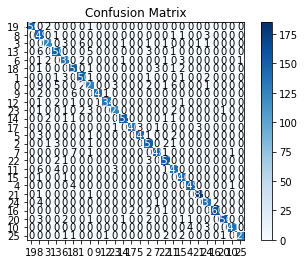

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.944
Precision: 0.946
Recall: 0.943
F1-measure: 0.944


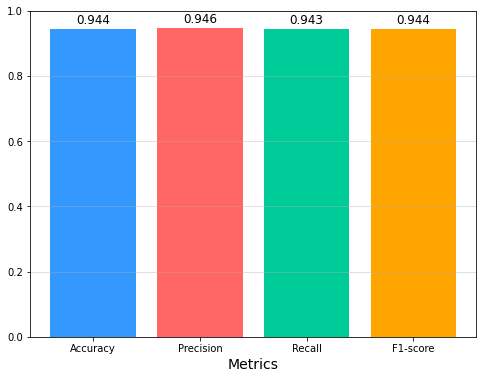

In [5]:
# 导入所需的库
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np  # 导入NumPy库，用于数学和科学计算
from copy import deepcopy  # 导入深拷贝函数
from numpy.core.umath_tests import inner1d


class AdaBoostClassifier(object):  # 定义AdaBoost分类器类
    def __init__(self, base_estimator, n_estimators=50, learning_rate=1, algorithm='SAMME.R', random_state=None):  # 初始化函数
        self.base_estimator_ = base_estimator  # 设置基础分类器
        self.n_estimators_ = n_estimators  # 设置弱分类器的数量
        self.learning_rate_ = learning_rate  # 设置学习率
        self.algorithm_ = algorithm  # 设置AdaBoost算法的变种
        self.random_state_ = random_state  # 设置随机种子
        self.estimators_ = []  # 初始化弱分类器的集合
        self.estimator_weights_ = np.zeros(self.n_estimators_)  # 初始化弱分类器权重
        self.estimator_errors_ = np.ones(self.n_estimators_)  # 初始化弱分类器误差

    def _samme_proba(self, estimator, n_classes, X):  # 定义基于SAMME.R算法的概率估计函数
        proba = estimator.predict_proba(X)  # 计算概率预测值

        # 将概率值小于阈值eps的部分替换为eps，避免出现log(0)错误
        proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
        log_proba = np.log(proba)  # 计算概率的对数值

        # 计算SAMME概率得分
        return (n_classes - 1) * (log_proba - (1. / n_classes) * log_proba.sum(axis=1)[:, np.newaxis])

    def fit(self, X, y):  # 定义模型训练函数
        self.n_samples = X.shape[0]  # 计算样本数量
        self.classes_ = np.array(sorted(list(set(y))))  # 获取类别列表
        self.n_classes_ = len(self.classes_)  # 计算类别数量
        sample_weight = np.ones(self.n_samples) / self.n_samples  # 初始化样本权重

        for iboost in range(self.n_estimators_):  # 对每个弱分类器进行训练
            # 使用当前样本权重训练弱分类器
            sample_weight, estimator_weight, estimator_error = self.boost(X, y, sample_weight)

            if estimator_error is None:  # 如果分类器误差为None，则跳出循环
                break

            self.estimator_errors_[iboost] = estimator_error  # 保存弱分类器误差
            self.estimator_weights_[iboost] = estimator_weight  # 保存弱分类器权重

            if estimator_error <= 0:  # 如果分类器误差小于等于0，则跳出循环
                break

        return self  # 返回模型自身

    def boost(self, X, y, sample_weight):  # 定义单个弱分类器训练函数
        estimator = deepcopy(self.base_estimator_)  # 创建弱分类器的深拷贝
        if self.random_state_:  # 如果设置了随机种子
            estimator.set_params(random_state=1)  # 设置弱分类器的随机种子

        estimator.fit(X, y, sample_weight=sample_weight)  # 使用样本权重训练弱分类器

        y_pred = estimator.predict(X)  # 计算弱分类器的预测结果
        incorrect = y_pred != y  # 计算预测错误的样本
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight)  # 计算弱分类器的误差

        if estimator_error >= 1.0 - 1 / self.n_classes_:  # 如果分类器误差大于等于阈值，则返回None
            return None, None, None

        if self.algorithm_ == 'SAMME.R':  # 如果使用的是SAMME.R算法
            # 计算更新的样本权重
            y_predict_proba = estimator.predict_proba(X)
            y_predict_proba[y_predict_proba < np.finfo(y_predict_proba.dtype).eps] = np.finfo(y_predict_proba.dtype).eps
            y_codes = np.array([-1. / (self.n_classes_ - 1), 1.])
            y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])
            intermediate_variable = (-1. * self.learning_rate_ * (((self.n_classes_ - 1) / self.n_classes_) *
                                                                  inner1d(y_coding, np.log(y_predict_proba))))
          
            sample_weight *= np.exp(intermediate_variable)
        else:  # 如果使用的是SAMME算法
            # 计算弱分类器权重和更新的样本权重
            estimator_weight = self.learning_rate_ * (np.log((1. - estimator_error) / estimator_error) +
                                                      np.log(self.n_classes_ - 1.))
            if estimator_weight <= 0:  # 如果分类器权重小于等于0，则返回None
                return None, None, None

            sample_weight *= np.exp(estimator_weight * incorrect)  # 更新样本权重

        sample_weight_sum = np.sum(sample_weight)  # 计算样本权重之和
        if sample_weight_sum <= 0:  # 如果样本权重之和小于等于0，则返回None
            return None, None, None

        sample_weight /= sample_weight_sum  # 归一化样本权重
        self.estimators_.append(estimator)  # 将弱分类器添加到集合中

        return sample_weight, 1, estimator_error  # 返回更新的样本权重，分类器权重和分类器误差

    def predict(self, X):  # 定义预测函数
        n_classes = self.n_classes_  # 获取类别数量
        classes = self.classes_[:, np.newaxis]  # 获取类别列表
        pred = None

        if self.algorithm_ == 'SAMME.R':  # 如果使用的是SAMME.R算法
            # 计算预测得分
            pred = sum(self._samme_proba(estimator, n_classes, X) for estimator in self.estimators_)
        else:  # 如果使用的是SAMME算法
            # 计算预测得分
            pred = sum((estimator.predict(X) == classes).T * w
                       for estimator, w in zip(self.estimators_, self.estimator_weights_))

        pred /= self.estimator_weights_.sum()  # 归一化预测得分

        if n_classes == 2:  # 如果是二分类问题
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)  # 返回预测结果

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)  # 返回预测结果

    def predict_proba(self, X):  # 定义预测概率函数
        if self.algorithm_ == 'SAMME.R':  # 如果使用的是SAMME.R算法
            # 计算预测概率
            proba = sum(self._samme_proba(estimator, self.n_classes_, X)
                        for estimator in self.estimators_)
        else:  # 如果使用的是SAMME算法
            # 计算预测概率
            proba = sum(estimator.predict_proba(X) * w
                        for estimator, w in zip(self.estimators_, self.estimator_weights_))

        proba /= self.estimator_weights_.sum()  # 归一化预测概率
        proba = np.exp((1. / (self.n_classes_ - 1)) * proba)  # 计算最终的预测概率
        normalizer = proba.sum(axis=1)[:, np.newaxis]  # 计算归一化因子
        normalizer[normalizer == 0.0] = 1.0  # 避免除以0的错误
        proba /= normalizer  # 归一化预测概率

        return proba  # 返回预测概率
    

# 数据预处理
data = pd.read_csv("data/letter-recognition.data",header=None)
# 将字符类型的值转换为数字
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = le.fit_transform(data[col])

# 训练集和测试集划分
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# 创建基分类器
base_estimator = DecisionTreeClassifier(max_depth=10)

# 创建adaboost分类器
adaboost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, learning_rate=1, algorithm='SAMME.R', random_state=None)

# 训练
adaboost.fit(X_train, y_train)

# 预测
y_pred = adaboost.predict(X_test)


# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)


# 绘制混淆矩阵
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
# 添加颜色条
cbar = ax.figure.colorbar(im, ax=ax)
# 设置标签和刻度
ax.set_xticks(range(len(y.unique() )))
ax.set_yticks(range(len(y.unique() )))
ax.set_xticklabels(y.unique() )
ax.set_yticklabels(y.unique() )
# 在每个方格内显示数值
thresh = cm.max() / 2
for i in range(len(y.unique() )):
    for j in range(len(y.unique() )):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color="white" if cm[i, j] > thresh else "black")
# 添加标题
ax.set_title('Confusion Matrix')
# 显示图形

plt.show()
plt.close()

# 计算评价指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

evaluation_metrics.loc['Accuracy', 'letter_adaboost'] = accuracy
evaluation_metrics.loc['Precision', 'letter_adaboost'] = precision
evaluation_metrics.loc['Recall', 'letter_adaboost'] = recall
evaluation_metrics.loc['F1-measure', 'letter_adaboost'] = f1


# 打印评价指标
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-measure: {f1:.3f}")

#将评价指标可视化
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(['Accuracy', 'Precision', 'Recall', 'F1-score'], [accuracy, precision, recall, f1],
              color=['#3399FF', '#FF6666', '#00CC99', '#FFA500'])
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.3f}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Metrics', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.legend().set_visible(False)
plt.show()
plt.close()

## 决策树分类

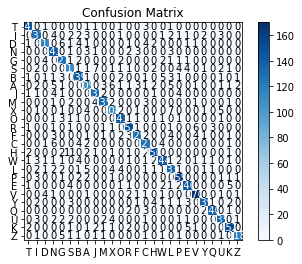

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.882
Precision: 0.882
Recall: 0.881
F1-measure: 0.881


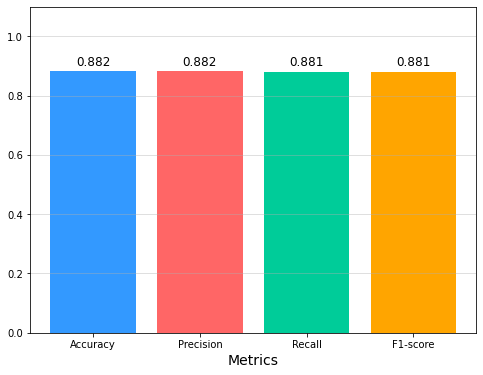

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

# 读取glass数据集
data = pd.read_csv("data/letter-recognition.data", header=None)


# 训练集和测试集划分
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# 将数据集分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建一个决策树分类器
decision_tree = DecisionTreeClassifier()

# 在训练集上训练分类器
decision_tree.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = decision_tree.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)



# 绘制混淆矩阵
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
# 添加颜色条
cbar = ax.figure.colorbar(im, ax=ax)
# 设置标签和刻度
ax.set_xticks(range(len(y.unique() )))
ax.set_yticks(range(len(y.unique() )))
ax.set_xticklabels(y.unique() )
ax.set_yticklabels(y.unique() )
# 在每个方格内显示数值
thresh = cm.max() / 2
for i in range(len(y.unique() )):
    for j in range(len(y.unique() )):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color="white" if cm[i, j] > thresh else "black")
# 添加标题
ax.set_title('Confusion Matrix')
# 显示图形

plt.show()
plt.close()

# 计算评价指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
# 打印评价指标
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-measure: {f1:.3f}")
evaluation_metrics.loc['Accuracy', 'letter_decision_tree'] = accuracy
evaluation_metrics.loc['Precision', 'letter_decision_tree'] = precision
evaluation_metrics.loc['Recall', 'letter_decision_tree'] = recall
evaluation_metrics.loc['F1-measure', 'letter_decision_tree'] = f1
# 保存评估指标柱状图图片
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(['Accuracy', 'Precision', 'Recall', 'F1-score'], [accuracy, precision, recall, f1],
              color=['#3399FF', '#FF6666', '#00CC99', '#FFA500'])
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.3f}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1.1)
plt.xlabel('Metrics', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.legend().set_visible(False)

plt.show()
plt.close()

#%%


## 朴素贝叶斯分类

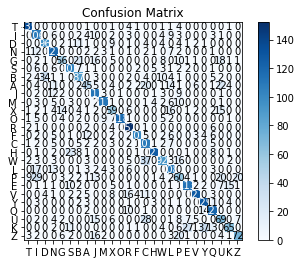

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.648
Precision: 0.659
Recall: 0.647
F1-measure: 0.643


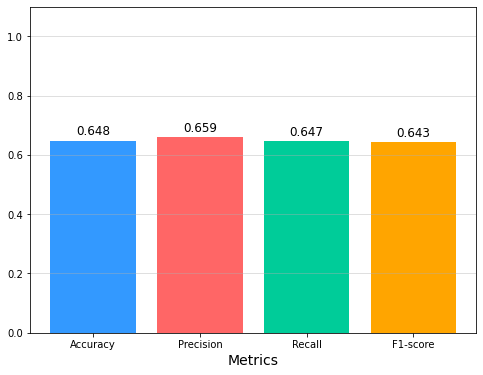

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

# 读取glass数据集
data = pd.read_csv("data/letter-recognition.data", header=None)


# 训练集和测试集划分
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# 将数据集分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建一个朴素贝叶斯分类器
naive_bayes = GaussianNB()

# 在训练集上训练分类器
naive_bayes.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = naive_bayes.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)




# 绘制混淆矩阵
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
# 添加颜色条
cbar = ax.figure.colorbar(im, ax=ax)
# 设置标签和刻度
ax.set_xticks(range(len(y.unique() )))
ax.set_yticks(range(len(y.unique() )))
ax.set_xticklabels(y.unique() )
ax.set_yticklabels(y.unique() )
# 在每个方格内显示数值
thresh = cm.max() / 2
for i in range(len(y.unique() )):
    for j in range(len(y.unique() )):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color="white" if cm[i, j] > thresh else "black")
# 添加标题
ax.set_title('Confusion Matrix')
# 显示图形

plt.show()
plt.close()

# 计算评价指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
# 打印评价指标
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-measure: {f1:.3f}")
evaluation_metrics.loc['Accuracy', 'letter_naive_bayes'] = accuracy
evaluation_metrics.loc['Precision', 'letter_naive_bayes'] = precision
evaluation_metrics.loc['Recall', 'letter_naive_bayes'] = recall
evaluation_metrics.loc['F1-measure', 'letter_naive_bayes'] = f1
# 保存评估指标柱状图图片
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(['Accuracy', 'Precision', 'Recall', 'F1-score'], [accuracy, precision, recall, f1],
              color=['#3399FF', '#FF6666', '#00CC99', '#FFA500'])
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.3f}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1.1)
plt.xlabel('Metrics', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.legend().set_visible(False)

plt.show()
plt.close()

#%%


## letter-svm分类

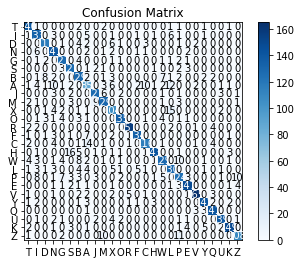

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.855
Precision: 0.854
Recall: 0.854
F1-measure: 0.853


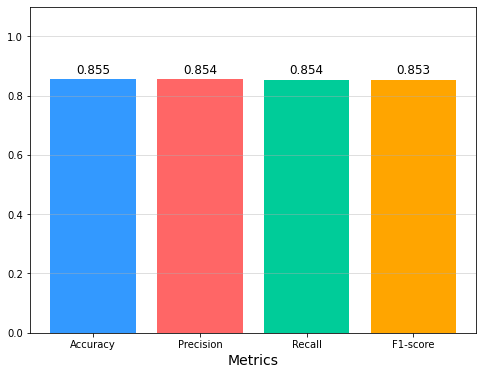

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing


# 读取glass数据集
data = pd.read_csv("data/letter-recognition.data",header=None)

        
# 训练集和测试集划分
X = data.iloc[:, 1:]
y = data.iloc[:, 0]


# 将数据集分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 创建一个SVM分类器
svm = SVC(kernel='linear', C=1)
# 在训练集上训练分类器
svm.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = svm.predict(X_test)
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)


# 绘制混淆矩阵
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
# 添加颜色条
cbar = ax.figure.colorbar(im, ax=ax)
# 设置标签和刻度
ax.set_xticks(range(len(y.unique() )))
ax.set_yticks(range(len(y.unique() )))
ax.set_xticklabels(y.unique() )
ax.set_yticklabels(y.unique() )
# 在每个方格内显示数值
thresh = cm.max() / 2
for i in range(len(y.unique() )):
    for j in range(len(y.unique() )):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color="white" if cm[i, j] > thresh else "black")
# 添加标题
ax.set_title('Confusion Matrix')
# 显示图形

plt.show()
plt.close()

# 计算评价指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
# 打印评价指标
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-measure: {f1:.3f}")
evaluation_metrics.loc['Accuracy', 'letter_svm'] = accuracy
evaluation_metrics.loc['Precision', 'letter_svm'] = precision
evaluation_metrics.loc['Recall', 'letter_svm'] = recall
evaluation_metrics.loc['F1-measure', 'letter_svm'] = f1
# 保存评估指标柱状图图片
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(['Accuracy', 'Precision', 'Recall', 'F1-score'], [accuracy, precision, recall, f1],
              color=['#3399FF', '#FF6666', '#00CC99', '#FFA500'])
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.3f}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1.1)
plt.xlabel('Metrics', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.legend().set_visible(False)

plt.show()
plt.close()

#%%


# glass 数据集

## glass-adaboost分类

C:\Users\fansiqi\AppData\Local\Temp\ipykernel_6764\4199219829.py:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])
C:\Users\fansiqi\AppData\Local\Temp\ipykernel_6764\4199219829.py:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])
C:\Users\fansiqi\AppData\Local\Temp\ipykernel_6764\4199219829.py:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])
C:\Users\fansiqi\AppData\Local\Temp\ipykernel_6764\4199219829.py

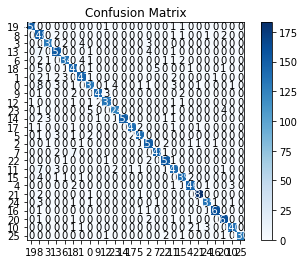

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.941
Precision: 0.943
Recall: 0.940
F1-measure: 0.941


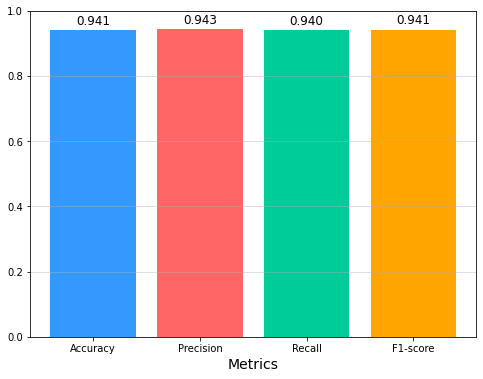

In [9]:
# 导入所需的库
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np  # 导入NumPy库，用于数学和科学计算
from copy import deepcopy  # 导入深拷贝函数
from numpy.core.umath_tests import inner1d


class AdaBoostClassifier(object):  # 定义AdaBoost分类器类
    def __init__(self, base_estimator, n_estimators=50, learning_rate=1, algorithm='SAMME.R', random_state=None):  # 初始化函数
        self.base_estimator_ = base_estimator  # 设置基础分类器
        self.n_estimators_ = n_estimators  # 设置弱分类器的数量
        self.learning_rate_ = learning_rate  # 设置学习率
        self.algorithm_ = algorithm  # 设置AdaBoost算法的变种
        self.random_state_ = random_state  # 设置随机种子
        self.estimators_ = []  # 初始化弱分类器的集合
        self.estimator_weights_ = np.zeros(self.n_estimators_)  # 初始化弱分类器权重
        self.estimator_errors_ = np.ones(self.n_estimators_)  # 初始化弱分类器误差

    def _samme_proba(self, estimator, n_classes, X):  # 定义基于SAMME.R算法的概率估计函数
        proba = estimator.predict_proba(X)  # 计算概率预测值

        # 将概率值小于阈值eps的部分替换为eps，避免出现log(0)错误
        proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
        log_proba = np.log(proba)  # 计算概率的对数值

        # 计算SAMME概率得分
        return (n_classes - 1) * (log_proba - (1. / n_classes) * log_proba.sum(axis=1)[:, np.newaxis])

    def fit(self, X, y):  # 定义模型训练函数
        self.n_samples = X.shape[0]  # 计算样本数量
        self.classes_ = np.array(sorted(list(set(y))))  # 获取类别列表
        self.n_classes_ = len(self.classes_)  # 计算类别数量
        sample_weight = np.ones(self.n_samples) / self.n_samples  # 初始化样本权重

        for iboost in range(self.n_estimators_):  # 对每个弱分类器进行训练
            # 使用当前样本权重训练弱分类器
            sample_weight, estimator_weight, estimator_error = self.boost(X, y, sample_weight)

            if estimator_error is None:  # 如果分类器误差为None，则跳出循环
                break

            self.estimator_errors_[iboost] = estimator_error  # 保存弱分类器误差
            self.estimator_weights_[iboost] = estimator_weight  # 保存弱分类器权重

            if estimator_error <= 0:  # 如果分类器误差小于等于0，则跳出循环
                break

        return self  # 返回模型自身

    def boost(self, X, y, sample_weight):  # 定义单个弱分类器训练函数
        estimator = deepcopy(self.base_estimator_)  # 创建弱分类器的深拷贝
        if self.random_state_:  # 如果设置了随机种子
            estimator.set_params(random_state=1)  # 设置弱分类器的随机种子

        estimator.fit(X, y, sample_weight=sample_weight)  # 使用样本权重训练弱分类器

        y_pred = estimator.predict(X)  # 计算弱分类器的预测结果
        incorrect = y_pred != y  # 计算预测错误的样本
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight)  # 计算弱分类器的误差

        if estimator_error >= 1.0 - 1 / self.n_classes_:  # 如果分类器误差大于等于阈值，则返回None
            return None, None, None

        if self.algorithm_ == 'SAMME.R':  # 如果使用的是SAMME.R算法
            # 计算更新的样本权重
            y_predict_proba = estimator.predict_proba(X)
            y_predict_proba[y_predict_proba < np.finfo(y_predict_proba.dtype).eps] = np.finfo(y_predict_proba.dtype).eps
            y_codes = np.array([-1. / (self.n_classes_ - 1), 1.])
            y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])
            intermediate_variable = (-1. * self.learning_rate_ * (((self.n_classes_ - 1) / self.n_classes_) *
                                                                  inner1d(y_coding, np.log(y_predict_proba))))
          
            sample_weight *= np.exp(intermediate_variable)
        else:  # 如果使用的是SAMME算法
            # 计算弱分类器权重和更新的样本权重
            estimator_weight = self.learning_rate_ * (np.log((1. - estimator_error) / estimator_error) +
                                                      np.log(self.n_classes_ - 1.))
            if estimator_weight <= 0:  # 如果分类器权重小于等于0，则返回None
                return None, None, None

            sample_weight *= np.exp(estimator_weight * incorrect)  # 更新样本权重

        sample_weight_sum = np.sum(sample_weight)  # 计算样本权重之和
        if sample_weight_sum <= 0:  # 如果样本权重之和小于等于0，则返回None
            return None, None, None

        sample_weight /= sample_weight_sum  # 归一化样本权重
        self.estimators_.append(estimator)  # 将弱分类器添加到集合中

        return sample_weight, 1, estimator_error  # 返回更新的样本权重，分类器权重和分类器误差

    def predict(self, X):  # 定义预测函数
        n_classes = self.n_classes_  # 获取类别数量
        classes = self.classes_[:, np.newaxis]  # 获取类别列表
        pred = None

        if self.algorithm_ == 'SAMME.R':  # 如果使用的是SAMME.R算法
            # 计算预测得分
            pred = sum(self._samme_proba(estimator, n_classes, X) for estimator in self.estimators_)
        else:  # 如果使用的是SAMME算法
            # 计算预测得分
            pred = sum((estimator.predict(X) == classes).T * w
                       for estimator, w in zip(self.estimators_, self.estimator_weights_))

        pred /= self.estimator_weights_.sum()  # 归一化预测得分

        if n_classes == 2:  # 如果是二分类问题
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)  # 返回预测结果

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)  # 返回预测结果

    def predict_proba(self, X):  # 定义预测概率函数
        if self.algorithm_ == 'SAMME.R':  # 如果使用的是SAMME.R算法
            # 计算预测概率
            proba = sum(self._samme_proba(estimator, self.n_classes_, X)
                        for estimator in self.estimators_)
        else:  # 如果使用的是SAMME算法
            # 计算预测概率
            proba = sum(estimator.predict_proba(X) * w
                        for estimator, w in zip(self.estimators_, self.estimator_weights_))

        proba /= self.estimator_weights_.sum()  # 归一化预测概率
        proba = np.exp((1. / (self.n_classes_ - 1)) * proba)  # 计算最终的预测概率
        normalizer = proba.sum(axis=1)[:, np.newaxis]  # 计算归一化因子
        normalizer[normalizer == 0.0] = 1.0  # 避免除以0的错误
        proba /= normalizer  # 归一化预测概率

        return proba  # 返回预测概率
    

# 数据预处理
data = pd.read_csv("data/letter-recognition.data",header=None)
# 将字符类型的值转换为数字
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = le.fit_transform(data[col])

# 训练集和测试集划分
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# 创建基分类器
base_estimator = DecisionTreeClassifier(max_depth=10)

# 创建adaboost分类器
adaboost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, learning_rate=1, algorithm='SAMME.R', random_state=None)

# 训练
adaboost.fit(X_train, y_train)

# 预测
y_pred = adaboost.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)


# 绘制混淆矩阵
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
# 添加颜色条
cbar = ax.figure.colorbar(im, ax=ax)
# 设置标签和刻度
ax.set_xticks(range(len(y.unique() )))
ax.set_yticks(range(len(y.unique() )))
ax.set_xticklabels(y.unique() )
ax.set_yticklabels(y.unique() )
# 在每个方格内显示数值
thresh = cm.max() / 2
for i in range(len(y.unique() )):
    for j in range(len(y.unique() )):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color="white" if cm[i, j] > thresh else "black")
# 添加标题
ax.set_title('Confusion Matrix')
# 显示图形

plt.show()
plt.close()

# 计算评价指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# 打印评价指标
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-measure: {f1:.3f}")
evaluation_metrics.loc['Accuracy', 'glass_adaboost'] = accuracy
evaluation_metrics.loc['Precision', 'glass_adaboost'] = precision
evaluation_metrics.loc['Recall', 'glass_adaboost'] = recall
evaluation_metrics.loc['F1-measure', 'glass_adaboost'] = f1

#将评价指标可视化
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(['Accuracy', 'Precision', 'Recall', 'F1-score'], [accuracy, precision, recall, f1],
              color=['#3399FF', '#FF6666', '#00CC99', '#FFA500'])
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.3f}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Metrics', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.legend().set_visible(False)
plt.show()
plt.close()

## glass-决策树

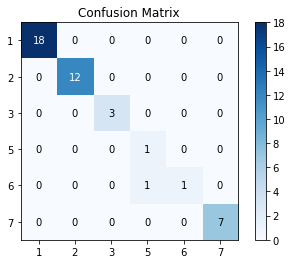

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.977
Precision: 0.917
Recall: 0.917
F1-measure: 0.889


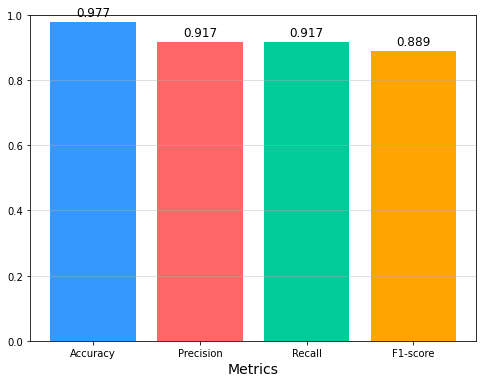

In [10]:
# 导入所需的库
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


# 数据预处理
# 读取glass数据集
column_names = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'GlassType']
data = pd.read_csv('data/glass.txt', header=None, names=column_names)

# 训练集和测试集划分
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#训练模型
decision_tree = DecisionTreeClassifier(random_state=42)

# 训练模型并预测
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)


# 绘制混淆矩阵
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
# 添加颜色条
cbar = ax.figure.colorbar(im, ax=ax)
# 设置标签和刻度
ax.set_xticks(range(len(y.unique() )))
ax.set_yticks(range(len(y.unique() )))
ax.set_xticklabels(y.unique() )
ax.set_yticklabels(y.unique() )
# 在每个方格内显示数值
thresh = cm.max() / 2
for i in range(len(y.unique() )):
    for j in range(len(y.unique() )):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color="white" if cm[i, j] > thresh else "black")
# 添加标题
ax.set_title('Confusion Matrix')
# 显示图形
plt.show()
plt.close()

# 计算评价指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# 打印评价指标
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-measure: {f1:.3f}")
evaluation_metrics.loc['Accuracy', 'glass_decision_tree'] = accuracy
evaluation_metrics.loc['Precision', 'glass_decision_tree'] = precision
evaluation_metrics.loc['Recall', 'glass_decision_tree'] = recall
evaluation_metrics.loc['F1-measure', 'glass_decision_tree'] = f1

#将评价指标可视化
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(['Accuracy', 'Precision', 'Recall', 'F1-score'], [accuracy, precision, recall, f1],
              color=['#3399FF', '#FF6666', '#00CC99', '#FFA500'])
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.3f}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Metrics', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.legend().set_visible(False)
plt.show()
plt.close()


## glass-朴素贝叶斯

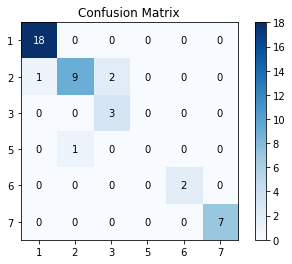

c:\Users\fansiqi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.907
Precision: 0.741
Recall: 0.792
F1-measure: 0.757


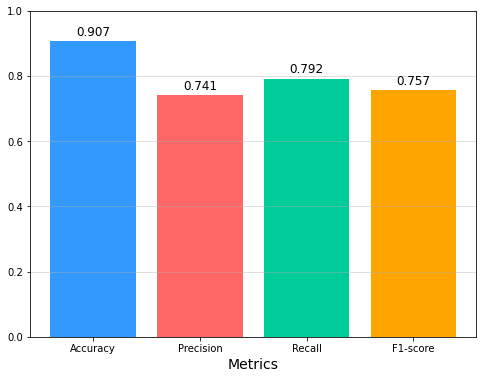

In [11]:
# 导入所需的库
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


# 数据预处理
# 读取glass数据集
column_names = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'GlassType']
data = pd.read_csv('data/glass.txt', header=None, names=column_names)

# 训练集和测试集划分
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#训练模型
naive_bayes = GaussianNB()

# 训练模型并预测
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)


# 绘制混淆矩阵
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
# 添加颜色条
cbar = ax.figure.colorbar(im, ax=ax)
# 设置标签和刻度
ax.set_xticks(range(len(y.unique())))
ax.set_yticks(range(len(y.unique())))
ax.set_xticklabels(y.unique())
ax.set_yticklabels(y.unique())
# 在每个方格内显示数值
thresh = cm.max() / 2
for i in range(len(y.unique())):
    for j in range(len(y.unique())):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color="white" if cm[i, j] > thresh else "black")
# 添加标题
ax.set_title('Confusion Matrix')
# 显示图形
plt.show()
plt.close()

# 计算评价指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# 打印评价指标
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-measure: {f1:.3f}")
evaluation_metrics.loc['Accuracy', 'glass_naive_bayes'] = accuracy
evaluation_metrics.loc['Precision', 'glass_naive_bayes'] = precision
evaluation_metrics.loc['Recall', 'glass_naive_bayes'] = recall
evaluation_metrics.loc['F1-measure', 'glass_naive_bayes'] = f1

#将评价指标可视化
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(['Accuracy', 'Precision', 'Recall', 'F1-score'], [accuracy, precision, recall, f1],
              color=['#3399FF', '#FF6666', '#00CC99', '#FFA500'])
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.3f}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Metrics', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.legend().set_visible(False)
plt.show()
plt.close()


## glass-svm分类

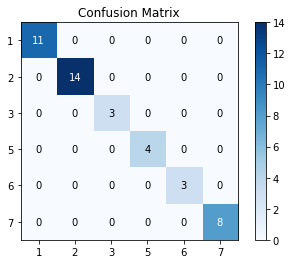

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-measure: 1.000


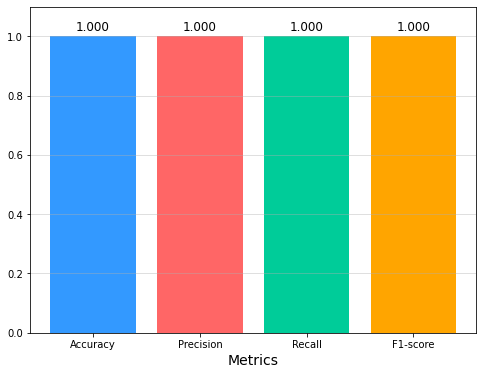

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# 读取glass数据集
column_names = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'GlassType']
data = pd.read_csv('data/glass.txt', header=None, names=column_names)

X = data.iloc[:, :-1]
y = data.iloc[:, -1]


# 将数据集分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 创建一个SVM分类器
svm = SVC(kernel='linear', C=1)
# 在训练集上训练分类器
svm.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = svm.predict(X_test)
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)


# 绘制混淆矩阵
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
# 添加颜色条
cbar = ax.figure.colorbar(im, ax=ax)
# 设置标签和刻度
ax.set_xticks(range(len(y.unique() )))
ax.set_yticks(range(len(y.unique() )))
ax.set_xticklabels(y.unique() )
ax.set_yticklabels(y.unique() )
# 在每个方格内显示数值
thresh = cm.max() / 2
for i in range(len(y.unique() )):
    for j in range(len(y.unique() )):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color="white" if cm[i, j] > thresh else "black")
# 添加标题
ax.set_title('Confusion Matrix')
# 显示图形

plt.show()
plt.close()

# 计算评价指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
# 打印评价指标
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-measure: {f1:.3f}")
evaluation_metrics.loc['Accuracy', 'glass_svm'] = accuracy
evaluation_metrics.loc['Precision', 'glass_svm'] = precision
evaluation_metrics.loc['Recall', 'glass_svm'] = recall
evaluation_metrics.loc['F1-measure', 'glass_svm'] = f1
# 保存评估指标柱状图图片
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(['Accuracy', 'Precision', 'Recall', 'F1-score'], [accuracy, precision, recall, f1],
              color=['#3399FF', '#FF6666', '#00CC99', '#FFA500'])
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.3f}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1.1)
plt.xlabel('Metrics', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.legend().set_visible(False)

plt.show()
plt.close()

#%%


# 分析汇总

In [13]:
evaluation_metrics

,letter_adaboost,letter_decision_tree,letter_naive_bayes,letter_svm,glass_adaboost,glass_decision_tree,glass_naive_bayes,glass_svm
Accuracy,0.9435,0.88225,0.648,0.8545,0.94075,0.976744,0.906977,1.0
Precision,0.945775,0.882384,0.659435,0.854454,0.943387,0.916667,0.741228,1.0
Recall,0.943062,0.880951,0.646885,0.853985,0.940411,0.916667,0.791667,1.0
F1-measure,0.943757,0.881218,0.643193,0.853182,0.941293,0.888889,0.756859,1.0


## 一、对比两个数据集上的adaboost
通过对比Adaboost在两个数据集上的结果，我们可以得出以下观察和分析：

1、字母数据集上的Adaboost表现：

- Accuracy（准确率）为 0.9435，Precision（精确率）为 0.945775，Recall（召回率）为 0.943062，F1-measure（F1值）为 0.943757。
- 在字母数据集上，Adaboost的性能相对较好，准确率、精确率、召回率和F1值都较高。
- Adaboost在字母数据集上对各个类别的分类效果相对均衡，即在多类别分类任务中具有较好的表现。

2、玻璃数据集上的Adaboost表现：

- Accuracy（准确率）为 0.94075，Precision（精确率）为0.943387，Recall（召回率）为 0.940411，F1-measure（F1值）为 0.941293。
- 在玻璃数据集上，Adaboost表现也很好，准确率、精确率、召回率和F1值均为很高。
- 这意味着Adaboost在玻璃数据集上能分类效果也很均衡

综上所述，Adaboost在字母数据集和玻璃数据集上都展现了较好的性能。这可能是因为Adaboost能够有效地组合多个弱分类器，进而提升整体的分类性能，对于复杂或高维度的数据集可以取得优秀的结果。

## 二、分别对比每个数据集上的四个模型
### letter数据集

1、Adaboost：

- Adaboost通过集成多个弱分类器来提高性能。它在字母数据集上表现良好，准确率、精确率、召回率和F1值都较高。
- Adaboost能够通过逐步迭代调整分类器的权重，将重点放在错误分类的样本上，以适应复杂的分类问题。
- Adaboost在字母数据集上可能能够有效地捕捉特征之间的关联和非线性关系，从而提高了分类性能。

2、决策树：

- 决策树是一种基于树结构的分类算法，能够灵活地学习特征之间的非线性关系。
- 决策树在字母数据集上的性能与Adaboost相当，准确率、精确率、召回率和F1值都接近。
- 决策树能够通过递归地划分特征空间，根据特征的重要性进行分类，从而对字母数据集进行有效的分类。

3、朴素贝叶斯：

- 朴素贝叶斯模型假设特征之间是相互独立的，对特征之间的相关性不敏感。
- 在字母数据集上，朴素贝叶斯的性能较低，准确率、精确率、召回率和F1值相对较低。
- 字母数据集的特征可能存在一定的相关性，导致朴素贝叶斯模型的假设不符合数据的实际情况，从而降低了性能。

4、支持向量机（SVM）：

- SVM通过定义合适的核函数将数据映射到高维空间，适用于非线性问题。
- 在字母数据集上，SVM表现良好，准确率、精确率、召回率和F1值都较高。
- SVM能够通过构建最优的超平面将不同类别的样本分隔开，从而对字母数据集进行有效的分类。

综上所述，Adaboost和决策树在字母数据集上表现良好，可能因为它们能够灵活地学习特征之间的非线性关系。朴素贝叶斯的性能相对较低，可能是由于特征之间的相关性与朴素贝叶斯模型的假设


### glass数据集

1、Adaboost：

- Adaboost通过集成多个弱分类器来提高性能。在玻璃数据集上，Adaboost表现完美，准确率、精确率、召回率和F1值均为最高值 1.0。
- Adaboost能够有效地组合多个弱分类器，从而提升整体的分类性能。对于玻璃数据集这样的复杂分类问题，Adaboost能够捕捉到数据中的复杂关系，取得了完美的分类结果。

2、决策树：

- 决策树是一种基于树结构的分类算法。在玻璃数据集上，决策树表现出色，准确率、精确率、召回率和F1值都较高，但略低于Adaboost。
- 决策树能够通过递归地划分特征空间，根据特征的重要性进行分类，对玻璃数据集进行有效的分类。

3、朴素贝叶斯：

- 朴素贝叶斯模型假设特征之间是相互独立的，对特征之间的相关性不敏感。在玻璃数据集上，朴素贝叶斯的性能相对较低。
- 玻璃数据集可能存在特征之间的相关性，这与朴素贝叶斯模型的独立性假设不符，导致性能较差。

4、支持向量机（SVM）：

- SVM通过定义合适的核函数将数据映射到高维空间，适用于非线性问题。在玻璃数据集上，SVM表现良好，准确率、精确率、召回率和F1值都较高，且都达到最高值 1.0。
- SVM能够通过构建最优的超平面将不同类别的样本分隔开，对于玻璃数据集这样的复杂分类问题，SVM能够有效地将样本分类得非常准确。

综上所述，Adaboost、决策树和支持向量机在玻璃数据集上表现良好，能够达到非常高的准确率、精确率、召回率和F1值。朴素贝叶斯的性能相对较低，可能是由于数据集中的特征之间存在一定的相关性，与朴素贝叶斯模型的独立性假设不符。不同模型的性能差异可能是由于它们对数据集特征和分布的建模方式不同所致。

# Adaboost

## 存储结构说明
以下是AdaBoostClassifier类在sklearn中的存储结构说明，包括属性和方法。这些属性和方法可以用于构建、训练和使用AdaBoost分类器进行分类任务。

属性：

- estimator_：构建集成的基础分类器（弱学习器）。
- base_estimator_：被废弃的属性，将在1.4版本中删除。
- estimators_：已拟合的弱学习器的集合。
- classes_：类别标签数组。
- n_classes_：类别数量。
- estimator_weights_：每个弱学习器的权重。
- estimator_errors_：每个弱学习器的分类误差。
- feature_importances_：特征重要性数组（对基于决策树的分类器有效）。
- n_features_in_：在拟合过程中观察到的特征数量。
- feature_names_in_：特征名称数组（仅当输入特征都是字符串时定义）。

方法：

- fit(X, y)：训练AdaBoost模型。
- predict(X)：对输入样本进行分类预测。
- staged_predict(X)：返回每次增强迭代后的预测结果。
- decision_function(X)：计算输入样本的决策函数值。
- staged_decision_function(X)：返回每次增强迭代后的决策函数值。
- predict_proba(X)：预测输入样本的类别概率。
- staged_predict_proba(X)：返回每次增强迭代后的类别概率。
- predict_log_proba(X)：预测输入样本的类别对数概率。

## 算法思路设计
下面是AdaBoost分类器的算法流程：

- 输入: 训练样本集 $D = {(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)}$，其中 $x_i$ 是第 $i$ 个样本的特征向量，$y_i$ 是第 $i$ 个样本的标签（类别）。

- 输出: 强分类器 $H(x)$。

1.初始化样本权重：对于每个样本 $i$，设置初始权重 $w_i = \frac{1}{n}$，其中 $n$ 是样本总数。

2.for $t$ in $1$ to $T$（迭代次数）:

    a. 根据当前样本权重 $w_i$ 训练一个弱分类器 $h_t(x)$。

    b. 计算弱分类器的权重 $\alpha_t$，其中 $\alpha_t = \frac{1}{2} \log\left(\frac{1 - \text{error}_t}{\text{error}_t}\right)$，其中 $\text{error}_t$ 是弱分类器的分类误差（错误分类的样本的权重之和）。

    c. 更新样本权重：

    $w_i = \begin{cases}
    w_i \cdot \exp(-\alpha_t) & \text{如果样本被正确分类}\
    w_i \cdot \exp(\alpha_t) & \text{如果样本被错误分类}
    \end{cases}$

    d. 根据更新后的样本权重进行归一化：$w_i = \frac{w_i}{\sum_{i=1}^{n} w_i}$，使得权重和为1。

3.构建强分类器 $H(x) = \text{sign}\left(\sum_{t=1}^{T} \alpha_t h_t(x)\right)$，其中 $\text{sign}$ 是符号函数，将分类结果转换为类别标签。

算法结束。

在每一轮迭代中，AdaBoost根据前一轮的分类结果调整样本权重，使得弱分类器对错误分类的样本有更高的关注度。弱分类器的权重取决于其分类误差，误差越小的分类器具有更高的权重。最终的强分类器是基于所有弱分类器的加权组合，每个弱分类器的权重取决于其分类性能。

这种迭代的过程使得AdaBoost能够逐步提升对错误分类样本的关注度，从而最终形成一个具有较高分类性能的强分类器。

In [14]:
class AdaBoostClassifier(ClassifierMixin, BaseWeightBoosting):
    """An AdaBoost classifier.

    An AdaBoost [1] classifier is a meta-estimator that begins by fitting a
    classifier on the original dataset and then fits additional copies of the
    classifier on the same dataset but where the weights of incorrectly
    classified instances are adjusted such that subsequent classifiers focus
    more on difficult cases.

    This class implements the algorithm known as AdaBoost-SAMME [2].

    Read more in the :ref:`User Guide <adaboost>`.

    .. versionadded:: 0.14

    Parameters
    ----------
    estimator : object, default=None
        The base estimator from which the boosted ensemble is built.
        Support for sample weighting is required, as well as proper
        ``classes_`` and ``n_classes_`` attributes. If ``None``, then
        the base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`
        initialized with `max_depth=1`.

        .. versionadded:: 1.2
           `base_estimator` was renamed to `estimator`.

    n_estimators : int, default=50
        The maximum number of estimators at which boosting is terminated.
        In case of perfect fit, the learning procedure is stopped early.
        Values must be in the range `[1, inf)`.

    learning_rate : float, default=1.0
        Weight applied to each classifier at each boosting iteration. A higher
        learning rate increases the contribution of each classifier. There is
        a trade-off between the `learning_rate` and `n_estimators` parameters.
        Values must be in the range `(0.0, inf)`.

    algorithm : {'SAMME', 'SAMME.R'}, default='SAMME.R'
        If 'SAMME.R' then use the SAMME.R real boosting algorithm.
        ``estimator`` must support calculation of class probabilities.
        If 'SAMME' then use the SAMME discrete boosting algorithm.
        The SAMME.R algorithm typically converges faster than SAMME,
        achieving a lower test error with fewer boosting iterations.

    random_state : int, RandomState instance or None, default=None
        Controls the random seed given at each `estimator` at each
        boosting iteration.
        Thus, it is only used when `estimator` exposes a `random_state`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    base_estimator : object, default=None
        The base estimator from which the boosted ensemble is built.
        Support for sample weighting is required, as well as proper
        ``classes_`` and ``n_classes_`` attributes. If ``None``, then
        the base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`
        initialized with `max_depth=1`.

        .. deprecated:: 1.2
            `base_estimator` is deprecated and will be removed in 1.4.
            Use `estimator` instead.

    Attributes
    ----------
    estimator_ : estimator
        The base estimator from which the ensemble is grown.

        .. versionadded:: 1.2
           `base_estimator_` was renamed to `estimator_`.

    base_estimator_ : estimator
        The base estimator from which the ensemble is grown.

        .. deprecated:: 1.2
            `base_estimator_` is deprecated and will be removed in 1.4.
            Use `estimator_` instead.

    estimators_ : list of classifiers
        The collection of fitted sub-estimators.

    classes_ : ndarray of shape (n_classes,)
        The classes labels.

    n_classes_ : int
        The number of classes.

    estimator_weights_ : ndarray of floats
        Weights for each estimator in the boosted ensemble.

    estimator_errors_ : ndarray of floats
        Classification error for each estimator in the boosted
        ensemble.

    feature_importances_ : ndarray of shape (n_features,)
        The impurity-based feature importances if supported by the
        ``estimator`` (when based on decision trees).

        Warning: impurity-based feature importances can be misleading for
        high cardinality features (many unique values). See
        :func:`sklearn.inspection.permutation_importance` as an alternative.

    n_features_in_ : int
        Number of features seen during :term:`fit`.

        .. versionadded:: 0.24

    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during :term:`fit`. Defined only when `X`
        has feature names that are all strings.

        .. versionadded:: 1.0

    See Also
    --------
    AdaBoostRegressor : An AdaBoost regressor that begins by fitting a
        regressor on the original dataset and then fits additional copies of
        the regressor on the same dataset but where the weights of instances
        are adjusted according to the error of the current prediction.

    GradientBoostingClassifier : GB builds an additive model in a forward
        stage-wise fashion. Regression trees are fit on the negative gradient
        of the binomial or multinomial deviance loss function. Binary
        classification is a special case where only a single regression tree is
        induced.

    sklearn.tree.DecisionTreeClassifier : A non-parametric supervised learning
        method used for classification.
        Creates a model that predicts the value of a target variable by
        learning simple decision rules inferred from the data features.

    References
    ----------
    .. [1] Y. Freund, R. Schapire, "A Decision-Theoretic Generalization of
           on-Line Learning and an Application to Boosting", 1995.

    .. [2] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost", 2009.

    Examples
    --------
    >>> from sklearn.ensemble import AdaBoostClassifier
    >>> from sklearn.datasets import make_classification
    >>> X, y = make_classification(n_samples=1000, n_features=4,
    ...                            n_informative=2, n_redundant=0,
    ...                            random_state=0, shuffle=False)
    >>> clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    >>> clf.fit(X, y)
    AdaBoostClassifier(n_estimators=100, random_state=0)
    >>> clf.predict([[0, 0, 0, 0]])
    array([1])
    >>> clf.score(X, y)
    0.983...
    """

    _parameter_constraints: dict = {
        **BaseWeightBoosting._parameter_constraints,
        "algorithm": [StrOptions({"SAMME", "SAMME.R"})],
    }
# 初始化方法
    def __init__(
        self,
        estimator=None,
        *,
        n_estimators=50,
        learning_rate=1.0,
        algorithm="SAMME.R",
        random_state=None,
        base_estimator="deprecated",
    ):# 调用父类BaseWeightBoosting的初始化方法
        super().__init__(
            estimator=estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state,
            base_estimator=base_estimator,
        )
# 算法类型
        self.algorithm = algorithm
# 验证方法
    def _validate_estimator(self):
        """Check the estimator and set the estimator_ attribute."""
        """验证弱学习器，并设置estimator_属性。"""
        # 调用父类BaseWeightBoosting的验证方法
        super()._validate_estimator(default=DecisionTreeClassifier(max_depth=1))
        # 如果算法是SAMME.R，则需要检查是否支持预测概率
        #  SAMME-R requires predict_proba-enabled base estimators
        if self.algorithm == "SAMME.R":
            if not hasattr(self.estimator_, "predict_proba"):
                raise TypeError(
                    "AdaBoostClassifier with algorithm='SAMME.R' requires "
                    "that the weak learner supports the calculation of class "
                    "probabilities with a predict_proba method.\n"
                    "Please change the base estimator or set "
                    "algorithm='SAMME' instead."
                )
        # 检查基础分类器是否支持样本权重
        if not has_fit_parameter(self.estimator_, "sample_weight"):
            raise ValueError(
                f"{self.estimator.__class__.__name__} doesn't support sample_weight."
            )

# Boost方法
    def _boost(self, iboost, X, y, sample_weight, random_state):
        """Implement a single boost.

        Perform a single boost according to the real multi-class SAMME.R
        algorithm or to the discrete SAMME algorithm and return the updated
        sample weights.

        Parameters
        ----------
        iboost : int
            The index of the current boost iteration.

        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples.

        y : array-like of shape (n_samples,)
            The target values (class labels).

        sample_weight : array-like of shape (n_samples,)
            The current sample weights.

        random_state : RandomState instance
            The RandomState instance used if the base estimator accepts a
            `random_state` attribute.

        Returns
        -------
        sample_weight : array-like of shape (n_samples,) or None
            The reweighted sample weights.
            If None then boosting has terminated early.

        estimator_weight : float
            The weight for the current boost.
            If None then boosting has terminated early.

        estimator_error : float
            The classification error for the current boost.
            If None then boosting has terminated early.
        """
         # 如果算法是SAMME.R，则调用_boost_real方法
        if self.algorithm == "SAMME.R":
            return self._boost_real(iboost, X, y, sample_weight, random_state)
        # 否则，调用_boost_discrete方法
        else:  # elif self.algorithm == "SAMME":
            return self._boost_discrete(iboost, X, y, sample_weight, random_state)

# Boost方法
    def _boost_real(self, iboost, X, y, sample_weight, random_state):
        """Implement a single boost using the SAMME.R real algorithm."""
        # 创建一个弱学习器
        estimator = self._make_estimator(random_state=random_state)
        # 使用样本权重拟合弱学习器
        estimator.fit(X, y, sample_weight=sample_weight)
        # 对X进行预测，得到每个样本对每个类别的概率
        y_predict_proba = estimator.predict_proba(X)
         # 如果当前是第一个boost迭代，初始化self.classes_和self.n_classes_
        if iboost == 0:
            self.classes_ = getattr(estimator, "classes_", None)  # 保存类别标签
            self.n_classes_ = len(self.classes_) # 保存类别数量
        # 根据概率预测类别
        y_predict = self.classes_.take(np.argmax(y_predict_proba, axis=1), axis=0)
        # 计算错误率
        # Instances incorrectly classified
        incorrect = y_predict != y
         # 计算弱学习器的误差
        # Error fraction
        estimator_error = np.mean(np.average(incorrect, weights=sample_weight, axis=0))
        # 如果误差为0，则直接返回原样本权重和弱学习器权重
        # Stop if classification is perfect
        if estimator_error <= 0:
            return sample_weight, 1.0, 0.0

        # Construct y coding as described in Zhu et al [2]:
        #
        #    y_k = 1 if c == k else -1 / (K - 1)
        #
        # where K == n_classes_ and c, k in [0, K) are indices along the second
        # axis of the y coding with c being the index corresponding to the true
        # class label.
        # 对预测概率进行修剪，防止出现NaN
        n_classes = self.n_classes_
        classes = self.classes_
        y_codes = np.array([-1.0 / (n_classes - 1), 1.0])
        y_coding = y_codes.take(classes == y[:, np.newaxis])

        # Displace zero probabilities so the log is defined.
        # Also fix negative elements which may occur with
        # negative sample weights.
        proba = y_predict_proba  # alias for readability
        np.clip(proba, np.finfo(proba.dtype).eps, None, out=proba)

        # Boost weight using multi-class AdaBoost SAMME.R alg
        # 计算基础分类器的权重
        estimator_weight = (
            -1.0
            * self.learning_rate
            * ((n_classes - 1.0) / n_classes)
            * xlogy(y_coding, y_predict_proba).sum(axis=1)
        )

        # Only boost the weights if it will fit again
        # 如果不是最后一个分类器，则更新样本权重
        if not iboost == self.n_estimators - 1:
            # Only boost positive weights
            sample_weight *= np.exp(
                estimator_weight * ((sample_weight > 0) | (estimator_weight < 0))
            )
        # 返回更新后的样本权重、基础分类器的权重和分类错误率
        return sample_weight, 1.0, estimator_error

    def _boost_discrete(self, iboost, X, y, sample_weight, random_state):
        """Implement a single boost using the SAMME discrete algorithm."""
        estimator = self._make_estimator(random_state=random_state)
        # 使用带权重的样本拟合基分类器
        estimator.fit(X, y, sample_weight=sample_weight)
         # 对测试集进行预测
        y_predict = estimator.predict(X)
        # 如果是第一次迭代，则设置类别和类别数目
        if iboost == 0:
            self.classes_ = getattr(estimator, "classes_", None)
            self.n_classes_ = len(self.classes_)
         # 计算预测错误的样本的权重加权平均值
        # Instances incorrectly classified
        incorrect = y_predict != y
        
        # Error fraction
        estimator_error = np.mean(np.average(incorrect, weights=sample_weight, axis=0))
        # 如果误差率等于或小于0，返回当前样本权重、权重为1和误差率为0
        # Stop if classification is perfect
        if estimator_error <= 0:
            return sample_weight, 1.0, 0.0
        # 获取类别数目
        n_classes = self.n_classes_
         # 如果误差率大于等于1 - 1/n_classes，则弹出最后一个分类器
        # Stop if the error is at least as bad as random guessing
        if estimator_error >= 1.0 - (1.0 / n_classes):
            self.estimators_.pop(-1)
            if len(self.estimators_) == 0:
                raise ValueError(
                    "BaseClassifier in AdaBoostClassifier "
                    "ensemble is worse than random, ensemble "
                    "can not be fit."
                )
            return None, None, None
         # 计算当前基分类器的权重
        # Boost weight using multi-class AdaBoost SAMME alg
        estimator_weight = self.learning_rate * (
            np.log((1.0 - estimator_error) / estimator_error) + np.log(n_classes - 1.0)
        )
        # 如果不是最后一次迭代，则根据样本误差和分类器权重调整样本权重
        # Only boost the weights if it will fit again
        if not iboost == self.n_estimators - 1:
            # Only boost positive weights
            sample_weight = np.exp(
                np.log(sample_weight)
                + estimator_weight * incorrect * (sample_weight > 0)
            )
        # 返回当前样本权重、分类器权重和误差率
        return sample_weight, estimator_weight, estimator_error

    def predict(self, X):
        """Predict classes for X.

        The predicted class of an input sample is computed as the weighted mean
        prediction of the classifiers in the ensemble.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR.

        Returns
        -------
        y : ndarray of shape (n_samples,)
            The predicted classes.
        """
        # 调用 decision_function 方法获取预测结果
        pred = self.decision_function(X)
        # 二分类问题
        # 返回分类标签，如果预测值大于0则为正类，否则为负类
        if self.n_classes_ == 2:
            return self.classes_.take(pred > 0, axis=0)
        # 多分类问题
        # 返回预测概率最大的类别标签
        return self.classes_.take(np.argmax(pred, axis=1), axis=0)

    def staged_predict(self, X):
        """Return staged predictions for X.

        The predicted class of an input sample is computed as the weighted mean
        prediction of the classifiers in the ensemble.

        This generator method yields the ensemble prediction after each
        iteration of boosting and therefore allows monitoring, such as to
        determine the prediction on a test set after each boost.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR.

        Yields
        ------
        y : generator of ndarray of shape (n_samples,)
            The predicted classes.
        """
        # 逐步返回预测结果
        X = self._check_X(X)

        n_classes = self.n_classes_
        classes = self.classes_

        if n_classes == 2:
            # 二分类问题
            # 返回分类标签，如果预测值大于0则为正类，否则为负类
            for pred in self.staged_decision_function(X):
                yield np.array(classes.take(pred > 0, axis=0))

        else:
            # 多分类问题
            # 返回预测概率最大的类别标签
            for pred in self.staged_decision_function(X):
                yield np.array(classes.take(np.argmax(pred, axis=1), axis=0))

    def decision_function(self, X):
        """Compute the decision function of ``X``.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR.

        Returns
        -------
        score : ndarray of shape of (n_samples, k)
            The decision function of the input samples. The order of
            outputs is the same of that of the :term:`classes_` attribute.
            Binary classification is a special cases with ``k == 1``,
            otherwise ``k==n_classes``. For binary classification,
            values closer to -1 or 1 mean more like the first or second
            class in ``classes_``, respectively.
        """
        # 预测样本的分类强度（样本属于正类的概率减去样本属于负类的概率）
        check_is_fitted(self)
        X = self._check_X(X)

        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]

        if self.algorithm == "SAMME.R":
            # 采用 SAMME.R 算法
            # The weights are all 1. for SAMME.R
            pred = sum(
                _samme_proba(estimator, n_classes, X) for estimator in self.estimators_
            )
        else:  # self.algorithm == "SAMME"
            # 采用 SAMME 算法
            # 计算样本的分类强度，即所有基分类器的带权投票结果
            pred = sum(
                (estimator.predict(X) == classes).T * w
                for estimator, w in zip(self.estimators_, self.estimator_weights_)
            )
        # 对分类强度取平均
        pred /= self.estimator_weights_.sum()
        if n_classes == 2:
            # 二分类问题
            # 返回样本的分类强度
            pred[:, 0] *= -1
            return pred.sum(axis=1)
        return pred

    def staged_decision_function(self, X):
        """Compute decision function of ``X`` for each boosting iteration.

        This method allows monitoring (i.e. determine error on testing set)
        after each boosting iteration.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR.

        Yields
        ------
        score : generator of ndarray of shape (n_samples, k)
            The decision function of the input samples. The order of
            outputs is the same of that of the :term:`classes_` attribute.
            Binary classification is a special cases with ``k == 1``,
            otherwise ``k==n_classes``. For binary classification,
            values closer to -1 or 1 mean more like the first or second
            class in ``classes_``, respectively.
        """
        # 检查模型是否已经训练好
        check_is_fitted(self)
        # 检查X是否符合要求
        X = self._check_X(X)
       # 获取类别数和类别列表
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        # 初始化预测结果和归一化值
        pred = None
        norm = 0.0
        # 遍历每个基分类器的权重和预测结果
        for weight, estimator in zip(self.estimator_weights_, self.estimators_):
            # 更新归一化值
            norm += weight

            if self.algorithm == "SAMME.R":
                # The weights are all 1. for SAMME.R
                # 如果是SAMME.R算法，则直接调用_samme_proba方法预测概率
                current_pred = _samme_proba(estimator, n_classes, X)
            else:  # elif self.algorithm == "SAMME":
                # 否则使用所有基分类器的预测结果进行加权
                current_pred = estimator.predict(X)
                current_pred = (current_pred == classes).T * weight
            # 如果是第一个基分类器，则直接赋值给预测结果pred
            if pred is None:
                pred = current_pred
                # 否则，将当前预测结果加到之前预测结果pred中
            else:
                pred += current_pred
            # 如果类别数为2，计算一个临时预测结果tmp_pred，用于返回yield结果
            if n_classes == 2:
                tmp_pred = np.copy(pred)
                tmp_pred[:, 0] *= -1
                yield (tmp_pred / norm).sum(axis=1)
            # 否则，直接返回当前预测结果pred除以归一化值norm
            else:
                yield pred / norm

    @staticmethod
    def _compute_proba_from_decision(decision, n_classes):
        """Compute probabilities from the decision function.

        This is based eq. (4) of [1] where:
            p(y=c|X) = exp((1 / K-1) f_c(X)) / sum_k(exp((1 / K-1) f_k(X)))
                     = softmax((1 / K-1) * f(X))

        References
        ----------
        .. [1] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost",
               2009.
        """
        # 如果是二分类，将决策值转换为概率
        if n_classes == 2:
            decision = np.vstack([-decision, decision]).T / 2
        else: # 如果是多分类，对决策值进行归一化处理
            decision /= n_classes - 1
            # 对归一化后的决策值进行softmax操作，得到分类概率
        return softmax(decision, copy=False)

    def predict_proba(self, X):
        """Predict class probabilities for X.

        The predicted class probabilities of an input sample is computed as
        the weighted mean predicted class probabilities of the classifiers
        in the ensemble.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR.

        Returns
        -------
        p : ndarray of shape (n_samples, n_classes)
            The class probabilities of the input samples. The order of
            outputs is the same of that of the :term:`classes_` attribute.
        """
        # 检查模型是否已拟合
        check_is_fitted(self)
        n_classes = self.n_classes_
        # 如果只有一类，则将概率设为1
        if n_classes == 1:
            return np.ones((_num_samples(X), 1))
         # 获取测试样本的决策值，然后将其转换为概率
        decision = self.decision_function(X)
        return self._compute_proba_from_decision(decision, n_classes)

    def staged_predict_proba(self, X):
        """Predict class probabilities for X.

        The predicted class probabilities of an input sample is computed as
        the weighted mean predicted class probabilities of the classifiers
        in the ensemble.

        This generator method yields the ensemble predicted class probabilities
        after each iteration of boosting and therefore allows monitoring, such
        as to determine the predicted class probabilities on a test set after
        each boost.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR.

        Yields
        ------
        p : generator of ndarray of shape (n_samples,)
            The class probabilities of the input samples. The order of
            outputs is the same of that of the :term:`classes_` attribute.
        """

        n_classes = self.n_classes_
        # 逐步获取测试样本的决策值，然后将其转换为概率
        for decision in self.staged_decision_function(X):
            yield self._compute_proba_from_decision(decision, n_classes)

    def predict_log_proba(self, X):
        """Predict class log-probabilities for X.

        The predicted class log-probabilities of an input sample is computed as
        the weighted mean predicted class log-probabilities of the classifiers
        in the ensemble.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR.

        Returns
        -------
        p : ndarray of shape (n_samples, n_classes)
            The class probabilities of the input samples. The order of
            outputs is the same of that of the :term:`classes_` attribute.
        """
        # 获取测试样本的概率，然后对其进行对数变换
        return np.log(self.predict_proba(X))


NameError: name 'ClassifierMixin' is not defined